In [2]:
import os
import nibabel as nib # python package that provides read/write access to some medical and neuroimaging file formats
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib qt
from scipy.spatial import ConvexHull, convex_hull_plot_2d # package for plotting convex hull
import os
import sys
import shutil
import scipy.io
from os.path import join as pjoin
from skimage.draw import polygon
import scipy.ndimage.measurements as measurements

base_dire = 'data\\1BrainCase\\data_converted_jun17'

C:\Users\hamsa\Anaconda3\lib\site-packages\dicom\__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)


In [3]:
## Load CT NIFTI data
data = nib.load(os.path.join(base_dire,'8d21ae84d6c99e3b417ca25383d9fc74_20180123_1_RTSTRUCT_CT__rtref.nii.gz')).get_fdata().T


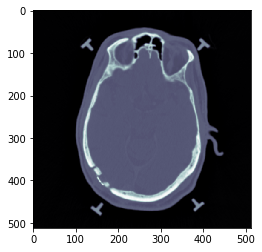

In [4]:
#data has shape: slice x column x row
#display for verification

%matplotlib inline
plt.imshow(data[90,:,:],cmap=plt.cm.bone)


1000.0

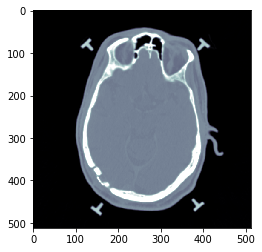

In [34]:
# clip the values in the matrix and plot to observe visual impact
data.clip(-1000, 1000, data)
plt.imshow(data[90,:,:],cmap=plt.cm.bone)
np.amax(data)

## RT struct file is tumor(Region of Interest) binary mask in patient coordinate system. 

## Using RT struct data in NIFTI format

Check how base directory will be structured when you get entire dataset

In [5]:
base='data\\1BrainCase\\data_converted_jun17\\8d21ae84d6c99e3b417ca25383d9fc74_20180123_1_CT_'
PTV = nib.load(os.path.join(base,'PTV3.nii.gz')).get_fdata().T
GTV = nib.load(os.path.join(base,'GTV3.nii.gz')).get_fdata().T

#Get coordinates of the pixels corresponding to 1. ie., get PTV and GTV coordinate points 
PTVPoints=np.argwhere(PTV==1)
GTVPoints=np.argwhere(GTV==1)

In [6]:
# max - min coordinates to get the width of tumor along each axis

np.set_printoptions(threshold=sys.maxsize)
kaxis=PTVPoints[:,0]
iaxis=PTVPoints[:,1]
jaxis=PTVPoints[:,2]
print(max(iaxis)- min(iaxis))
print(max(jaxis)- min(jaxis))
print(max(kaxis)- min(kaxis))
size=max(max(iaxis)- min(iaxis),max(jaxis)- min(jaxis),max(kaxis)- min(kaxis))
print(size)

17
19
8
19


In [7]:
# Since the mask has binary values, find sum along each axis. 
# The max value along each axis gives the max width of tumor in that axis
np.amax(np.sum(PTV, axis=0))
print(np.amax(np.sum(PTV, axis=0)))
print(np.amax(np.sum(PTV, axis=1)))
print(np.amax(np.sum(PTV, axis=2)))

9.0
18.0
18.0


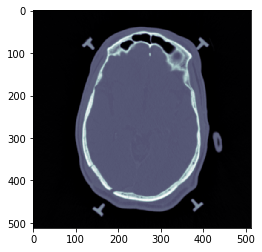

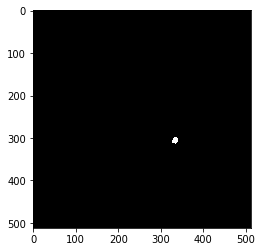

In [8]:
#display for verification
slice_no=97
# plot CT sequence
plt.imshow(data[slice_no,:,:],cmap=plt.cm.bone)
plt.figure()
# plot PTV
plt.imshow(PTV[slice_no,:,:],cmap=plt.cm.bone)

In [9]:
# Get approximate center of mass of PTV 

com=measurements.center_of_mass(PTV)
com_point=[int(i) for i in com]
print(f'center of mass',com_point)

center of mass [94, 305, 334]


In [10]:
##Check headers data

RTheadr=nib.load(os.path.join(base,'PTV3.nii.gz')).header
print(f'RT struct header: {RTheadr}')
print('********************************')
#print(f'CT header: {data.header}')

RT struct header: <class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3 512 512 206   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : uint8
bitpix          : 8
slice_start     : 0
pixdim          : [1.         0.48828125 0.48828125 1.         0.         0.
 0.         0.        ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 2
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : scanner
sform_code      : unknown
quatern_b       : 0.0
quatern_c       : 0.0
quatern_d       : 1.0
qoffset_x       : 124.75586
qoffset_y       : 40

In [11]:
#items corresponding to GTV and PTV in order

tumorPoints=[GTVPoints, PTVPoints]
# order slices in descending order for visualization
tumorSliceSet=[sorted(list(set(GTVPoints[:,0]))), sorted(list(set(PTVPoints[:,0])))]
marker=['r--','b--']


## Plot and compare ROI contour plots with scatterplot and convexHull methood

### scatterplot ROI

In [12]:

%matplotlib qt

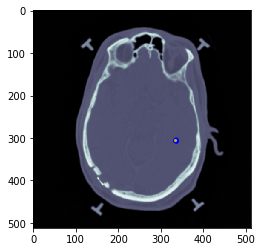

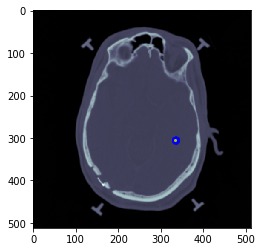

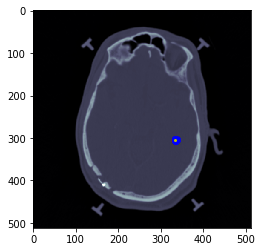

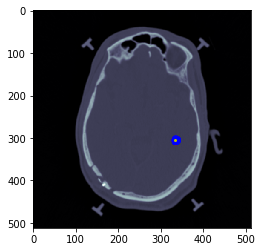

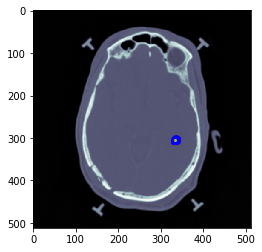

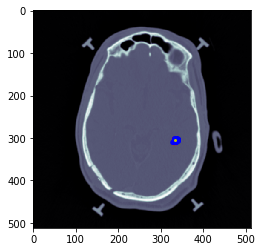

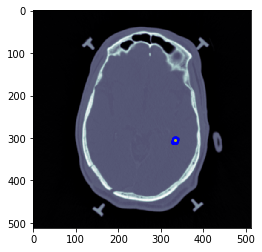

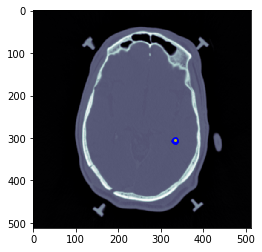

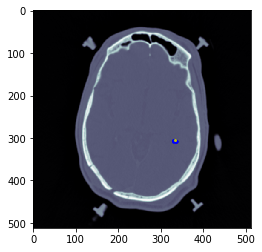

In [13]:

## Try to remove entire tree; if failed show an error
'''try:
    shutil.rmtree("results")
except OSError as e:
    print ("Error: %s - %s." % (e.filename, e.strerror))

if not os.path.exists('results'):
    os.makedirs('results')
    '''
size_of_plot_point=[5,1]
marker2=['r','b']
# PTV is super set.
for i,slicee in enumerate(tumorSliceSet[1]):
    fig = plt.figure()
    #plot PTV and GTV contours for each slice
    for j,center in enumerate(tumorPoints):
        #Using PTV as super set. GTV doesnt exist in some slice. This is to avoid the error
        if slicee in tumorSliceSet[j]:
            #get centers for this particular slice only
            centers=tumorPoints[j][np.where(tumorPoints[j][:,0]==slicee)]
           # print(centers)
            x, y = centers[:,[2]],centers[:,[1]]
            plt.scatter(x,y, s=size_of_plot_point[j], c=marker2[j])
    #plot center of mass
    plt.plot(com_point[2],com_point[1], 'yo',markersize=2)
    plt.imshow(data[slicee,:,:],cmap=plt.cm.bone)
    fname= 'results\\'+'slice '+ str(slicee)
    #print(fname)
    #plt.savefig(fname, bbox_inches='tight')

### Convex hull ROI

In [16]:
import matplotlib.patches as patches
  
# PTV is super set.
for i,slicee in enumerate(tumorSliceSet[1]):
    fig = plt.figure()
    #plot PTV and GTV contours for each slice
    for j,center in enumerate(tumorPoints):
        #Using PTV as super set. GTV doesnt exist in some slices. This is to avoid the error
        if slicee in tumorSliceSet[j]:
            #get centers for this particular slice only
            centers=tumorPoints[j][np.where(tumorPoints[j][:,0]==slicee)]
            #print(centers)
            #plt.plot(centers[:,0], centers[:,1], 'o')
            hull = ConvexHull(centers[:,[1,2]])
            for simplex in hull.simplices: 
                plt.plot(centers[simplex, 2], centers[simplex, 1], marker[j], linewidth=1.2)
                #print(centers[simplex, 0])
    #plot center of mass
    #plt.plot(com_point[2],com_point[1], 'yo',markersize=2)
    #print('v',com_point[:2])
    plt.imshow(data[slicee,:,:],cmap=plt.cm.bone)
    ax = plt.gca()
    coordinates=(com_point[2]-size/2, com_point[1]-size/2)
    print(f'coordinates{coordinates}')
    rect = patches.Rectangle((coordinates),
                 size,
                 size,
                 linewidth=1,
                 edgecolor='cyan',
                 fill = False)

    ax.add_patch(rect)

    plt.show()
    fname= 'results\\'+'slice '+ str(slicee)
    #print(fname)
    #plt.savefig(fname, bbox_inches='tight')
    
    


coordinates(324.5, 295.5)
coordinates(324.5, 295.5)
coordinates(324.5, 295.5)
coordinates(324.5, 295.5)
coordinates(324.5, 295.5)
coordinates(324.5, 295.5)
coordinates(324.5, 295.5)
coordinates(324.5, 295.5)
coordinates(324.5, 295.5)


## Trial with RT struct file in .mat file along with CT NIFTI


In [ ]:
if not os.path.exists('MatResults'):
    os.makedirs('MatResults')


mat_fname = pjoin('data\\1BrainCase\\', 'PTV3 and GTV3.mat')
mat = scipy.io.loadmat(mat_fname)
PTV_mat=mat['PTV3']
GTV_mat=mat['GTV3']


PTVPoints_mat=np.argwhere(PTV_mat==1)
GTVPoints_mat=np.argwhere(GTV_mat==1)

tumorPoints_mat=[GTVPoints_mat, PTVPoints_mat]
tumorSliceSet_mat=[sorted(list(set(GTVPoints_mat[:,2]))), sorted(list(set(PTVPoints_mat[:,2])))]
marker_mat=['r--','b--']


# PTV is super set.
for i,slicee in enumerate(tumorSliceSet_mat[1]):
    fig = plt.figure()
    #plot PTV and GTV contours for each slice
    for j,center in enumerate(tumorPoints_mat):
        #Using PTV as super set. GTV doesnt exist in some slice. This is to avoid the error
        if slicee in tumorSliceSet_mat[j]:
            centers_mat=tumorPoints_mat[j][np.where(tumorPoints_mat[j][:,2]==slicee)]
            #print(f'{slicee}: {centers_mat}')
            hull_mat = ConvexHull(centers_mat[:,[0,1]])
            for simplex in hull_mat.simplices: 
                #-----Needed to swap row and column coordinates for correct location----#
                plt.plot(centers_mat[simplex, 1], centers_mat[simplex, 0], marker_mat[j], linewidth=0.75)
    plt.imshow(data.get_fdata()[:,:,slicee].transpose(),cmap=plt.cm.bone)
    fname= 'MatResults\\'+'slice '+ str(slicee)
    plt.savefig(fname, bbox_inches='tight')
            
